# D.4. Commodity Futures

## Markets Foundations

### UChicago Financial Mathematics

#### September 2023

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
#from utils import *
from portfolio import *

In [2]:
LOADFILE = '../data/futures_data.xlsx'
futures_info = pd.read_excel(LOADFILE,sheet_name='futures contracts').set_index('symbol')

# Definition

A futures contract is an agreement
* entered at $t$
* to purchase an asset at $T$
* for a price $F$

It is an obligation, not an option!

We will return to some key differences between futures and forwards.


### Assets

Futures contracts are an important way to trade commodities including
* energy
* metals
* grains
* livestock

Futures contracts are traded widely on many assets beyond commodities:
* interest-rate products
* currency
* equity indexes
* other indexes

### Data on Variety

The correlation heatmap below gives a sense of the range of products.
* Most bond correlations are 80%+
* Most stock correlations are 60%+

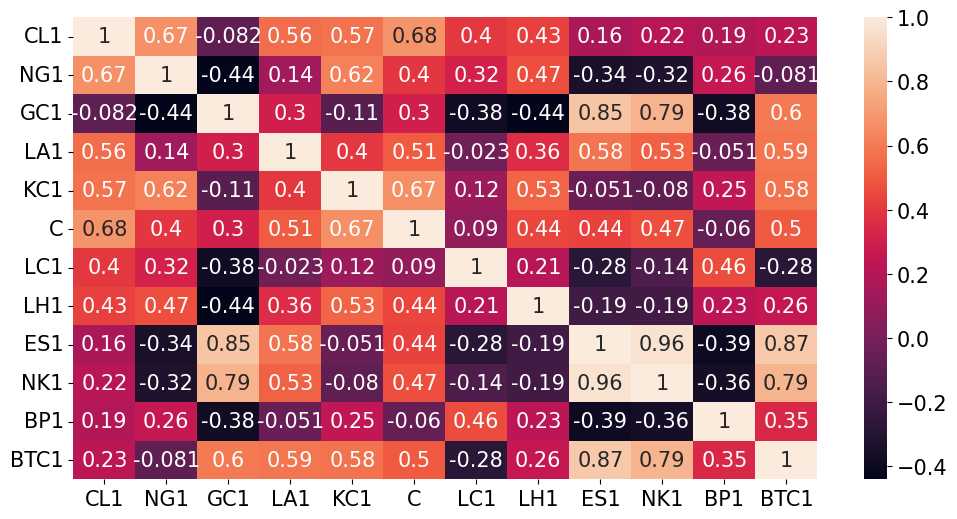

In [3]:
ADJLAB = 'roll=ratio'
futures_hist = pd.read_excel(LOADFILE,sheet_name=f'continuous futures {ADJLAB}').set_index('date')
corrmat = futures_hist.loc['2015':,:].corr()
sns.heatmap(corrmat,annot=True);

### Variety of means and volatilities

In [4]:
px = futures_hist.copy()
px[px<0] = np.nan
rx = px.pct_change().dropna()

performanceMetrics(rx,annualization=252).iloc[:,0:2].style.format('{:.1%}')

,Mean,Vol
CL1,17.8%,53.5%
NG1,11.1%,64.5%
GC1,6.1%,14.9%
LA1,0.6%,22.4%
KC1,6.2%,33.0%
C,14.7%,23.4%
LC1,3.7%,16.3%
LH1,1.9%,35.0%
ES1,10.7%,20.6%
NK1,10.9%,19.6%


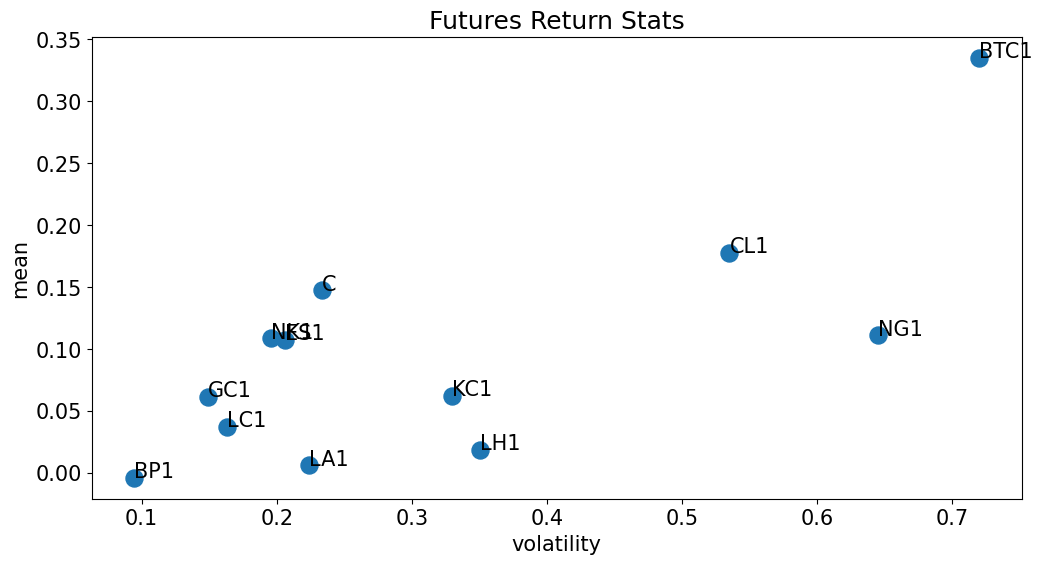

In [5]:
df = performanceMetrics(rx,annualization=252).iloc[:,0:2]
df.index.name = 'symbol'
df.reset_index(inplace=True)

fig, ax = plt.subplots()
ax.scatter(x=df['Vol'],y=df['Mean'],s=150)
ax.set_xlabel('volatility')
ax.set_ylabel('mean')

for idx, row in df.iterrows():
    ax.annotate(row['symbol'], (row['Vol'], row['Mean']))

plt.title('Futures Return Stats')
plt.show()

# Trading

## Exchanges

**Futures** trade on exchanges. In U.S. markets, the following two exchanges are of particular note:

* Chicago Mercantile Exchange (CME)
* Intercontinental Exchange (ICE)

In recent years, the trading has moved to being overwhelmingly (and at many exchanges, completely,) electronic.

### Standardization
One role of an exchange is to standardize the trading, which allows for better liquidity.

This is especially useful in commodities, to set the grade, size, location of the asset.

### Clearing
As part of trading on an exchange, futures are **centrally cleared.** This is important for 
* eliminating counterparty risk
* achieving better netting and margin requirements

### Settlement

Settlement may be via
* delivery of the asset
* cash payment equal to the spot price of the asset

Note that there is cash delivery for
* equity indexes
* bitcoin (index)
But there is also cash delivery for some physical assets
* Hogs are delivered via cash
* Cattle are delivered physically

In [6]:
futures_info[['name','category','delivery type']]

,name,category,delivery type
symbol,,,
CL,WTI CRUDE FUTURE Aug23,Crude Oil,PHYS
NG,NATURAL GAS FUTR Aug23,Natural Gas,PHYS
GC,GOLD 100 OZ FUTR Aug23,Precious Metal,PHYS
AH,LME PRI ALUM FUTR Aug23,Base Metal,PHYS
KC,COFFEE 'C' FUTURE Sep23,Foodstuff,PHYS
ZC,CORN FUTURE Dec23,Corn,PHYS
LE,LIVE CATTLE FUTR Oct23,Livestock,PHYS
HE,LEAN HOGS FUTURE Oct23,Livestock,CASH
ES,S&P500 EMINI FUT Sep23,Equity Index,CASH


In [7]:
futures_info

,bb ticker,name,type,category,delivery type,exchange,contract date,contract size,last_price,contract value,crncy,margin limit,tick size,tick value,open interest,volume,volume 10d avg
symbol,,,,,,,,,,,,,,,,,
CL,CLA Comdty,WTI CRUDE FUTURE Aug23,Physical commodity future.,Crude Oil,PHYS,New York Mercantile Exchange,2023-08-01,1000,74.370,74370.00,USD,5800.0,0.010,10.00,138498,197005,347826.2
NG,NGA Comdty,NATURAL GAS FUTR Aug23,Physical commodity future.,Natural Gas,PHYS,New York Mercantile Exchange,2023-08-01,10000,2.521,25210.00,USD,4000.0,0.001,10.00,108685,88112,125200.7
GC,GCA Comdty,GOLD 100 OZ FUTR Aug23,Physical commodity future.,Precious Metal,PHYS,"Commodity Exchange, Inc.",2023-08-01,100,1959.200,195920.00,USD,8300.0,0.100,10.00,240346,154159,214421.1
AH,LAA Comdty,LME PRI ALUM FUTR Aug23,Physical commodity future.,Base Metal,PHYS,London Metal Exchange,2023-08-01,25,2250.000,56250.00,USD,NaN,0.010,0.25,53232,49557,34346.7
KC,KCA Comdty,COFFEE 'C' FUTURE Sep23,Physical commodity future.,Foodstuff,PHYS,ICE Futures US Softs,2023-09-01,37500,155.800,58425.00,USD,6750.0,0.050,18.75,91530,22289,17368.4
ZC,C A Comdty,CORN FUTURE Dec23,Physical commodity future.,Corn,PHYS,Chicago Board of Trade,2023-12-01,5000,506.000,25300.00,USD,2300.0,0.250,12.50,564960,154303,178648.7
LE,LCA Comdty,LIVE CATTLE FUTR Oct23,Physical commodity future.,Livestock,PHYS,Chicago Mercantile Exchange,2023-10-01,40000,182.475,72990.00,USD,1850.0,0.025,10.00,133247,35899,26848.3
HE,LHA Comdty,LEAN HOGS FUTURE Oct23,Physical commodity future.,Livestock,CASH,Chicago Mercantile Exchange,2023-10-01,40000,82.350,32940.00,USD,1750.0,0.025,10.00,72754,18304,19510.1
ES,ESA Index,S&P500 EMINI FUT Sep23,Physical index future.,Equity Index,CASH,Chicago Mercantile Exchange,2023-09-01,50,4554.500,227725.00,USD,11200.0,0.250,12.50,2241106,690887,1406809.7


## Quoting Conventions

https://www.cmegroup.com/markets/energy/crude-oil/light-sweet-crude.contractSpecs.html

### Multiple

In [8]:
futures_info[['name','contract size','contract value']].style.format({'contract size':'{:,.0f}','contract value':'${:,.0f}'})

,name,contract size,contract value
symbol,,,
CL,WTI CRUDE FUTURE Aug23,"1,000","$74,370"
NG,NATURAL GAS FUTR Aug23,"10,000","$25,210"
GC,GOLD 100 OZ FUTR Aug23,100,"$195,920"
AH,LME PRI ALUM FUTR Aug23,25,"$56,250"
KC,COFFEE 'C' FUTURE Sep23,"37,500","$58,425"
ZC,CORN FUTURE Dec23,"5,000","$25,300"
LE,LIVE CATTLE FUTR Oct23,"40,000","$72,990"
HE,LEAN HOGS FUTURE Oct23,"40,000","$32,940"
ES,S&P500 EMINI FUT Sep23,50,"$227,725"


### Tick Size

In [9]:
futures_info[['name','tick size','tick value']].style.format({'tick size':'{:.3f}','tick value':'{:.2f}'})

,name,tick size,tick value
symbol,,,
CL,WTI CRUDE FUTURE Aug23,0.010,10.00
NG,NATURAL GAS FUTR Aug23,0.001,10.00
GC,GOLD 100 OZ FUTR Aug23,0.100,10.00
AH,LME PRI ALUM FUTR Aug23,0.010,0.25
KC,COFFEE 'C' FUTURE Sep23,0.050,18.75
ZC,CORN FUTURE Dec23,0.250,12.50
LE,LIVE CATTLE FUTR Oct23,0.025,10.00
HE,LEAN HOGS FUTURE Oct23,0.025,10.00
ES,S&P500 EMINI FUT Sep23,0.250,12.50


## Open Interest

**Open Interest** measures the number of open positions for the specific futures contract, cumulated over time.

**Volume** is the number of contracts traded that period (daily below).

See the chart below for the difference

In [10]:
futures_info[['name','open interest','volume','volume 10d avg']].style.format({'open interest':'{:,.0f}','volume':'{:,.0f}','volume 10d avg':'{:,.0f}'})

,name,open interest,volume,volume 10d avg
symbol,,,,
CL,WTI CRUDE FUTURE Aug23,"138,498","197,005","347,826"
NG,NATURAL GAS FUTR Aug23,"108,685","88,112","125,201"
GC,GOLD 100 OZ FUTR Aug23,"240,346","154,159","214,421"
AH,LME PRI ALUM FUTR Aug23,"53,232","49,557","34,347"
KC,COFFEE 'C' FUTURE Sep23,"91,530","22,289","17,368"
ZC,CORN FUTURE Dec23,"564,960","154,303","178,649"
LE,LIVE CATTLE FUTR Oct23,"133,247","35,899","26,848"
HE,LEAN HOGS FUTURE Oct23,"72,754","18,304","19,510"
ES,S&P500 EMINI FUT Sep23,"2,241,106","690,887","1,406,810"


#### Closing Positions

Most open interest is ultimately closed via **offsetting contracts, NOT delivery**.

Consider the open interest for various contracts on Crude Oil (CL) and Gold (GC).

For each contract, we see the open interest rises about a month before the delivery, and then drops to nearly zero just before delivery.

In [11]:
TICKS = ['CL','GC']

futures_ts = pd.read_excel(LOADFILE,sheet_name='futures timeseries',header=[0,1,2]).droplevel(2,axis=1)
futures_ts.set_index(futures_ts.columns[0],inplace=True)
futures_ts.index.name = 'date'
futures_ts = futures_ts.swaplevel(axis=1)

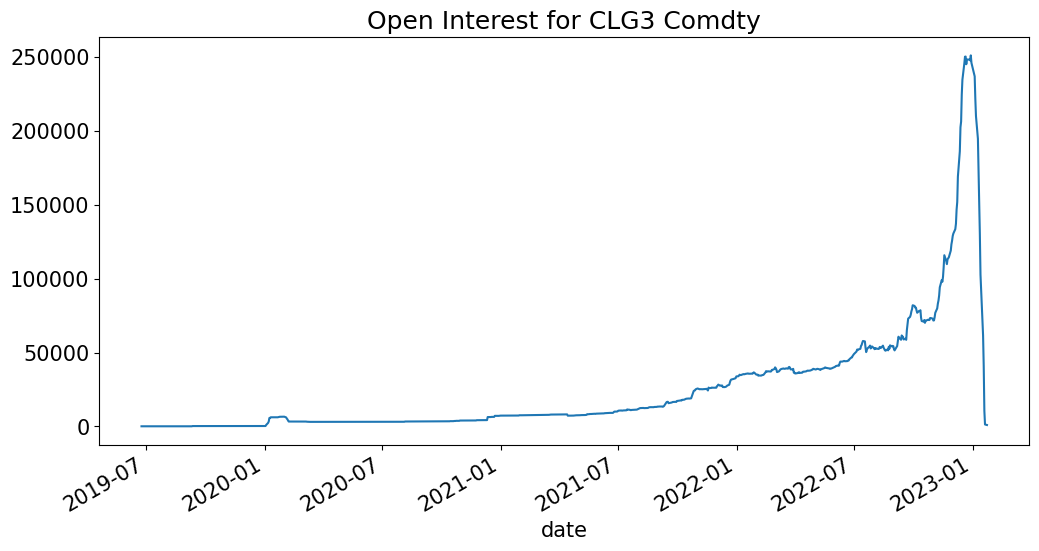

In [12]:
idx = 0
exname = futures_ts['OPEN_INT'].iloc[:,idx].name
exdata = futures_ts['OPEN_INT'].iloc[:,idx].dropna()
exdata.plot(title=f'Open Interest for {exname}');

In [13]:
intpct = exdata[-1]/exdata.max()
print(f'Open Interest at close is {intpct:.2%} of its peak!')

Open Interest at close is 0.39% of its peak!


### Active Contract

For a given futures chain, only a few are liquid. 

The **active contract** is typically denoted as the front-month (nearest expiration) which typically corresponds with the contract with the highest **open interest**.

For the two examples below, we see that the soonest-to-expiry sees a spike in open interest, with the second-nearest expiry rising in anticipation of being the active contract.

### Liquidity

Thus, the active contract tends to be **much** more liquid , as measured by volume or open interest.

As a corollary, a contract will be listed, yet may receive almost zero interest or volume for months or years.

In the example **above**, note that the open interest is miniscule for a year.

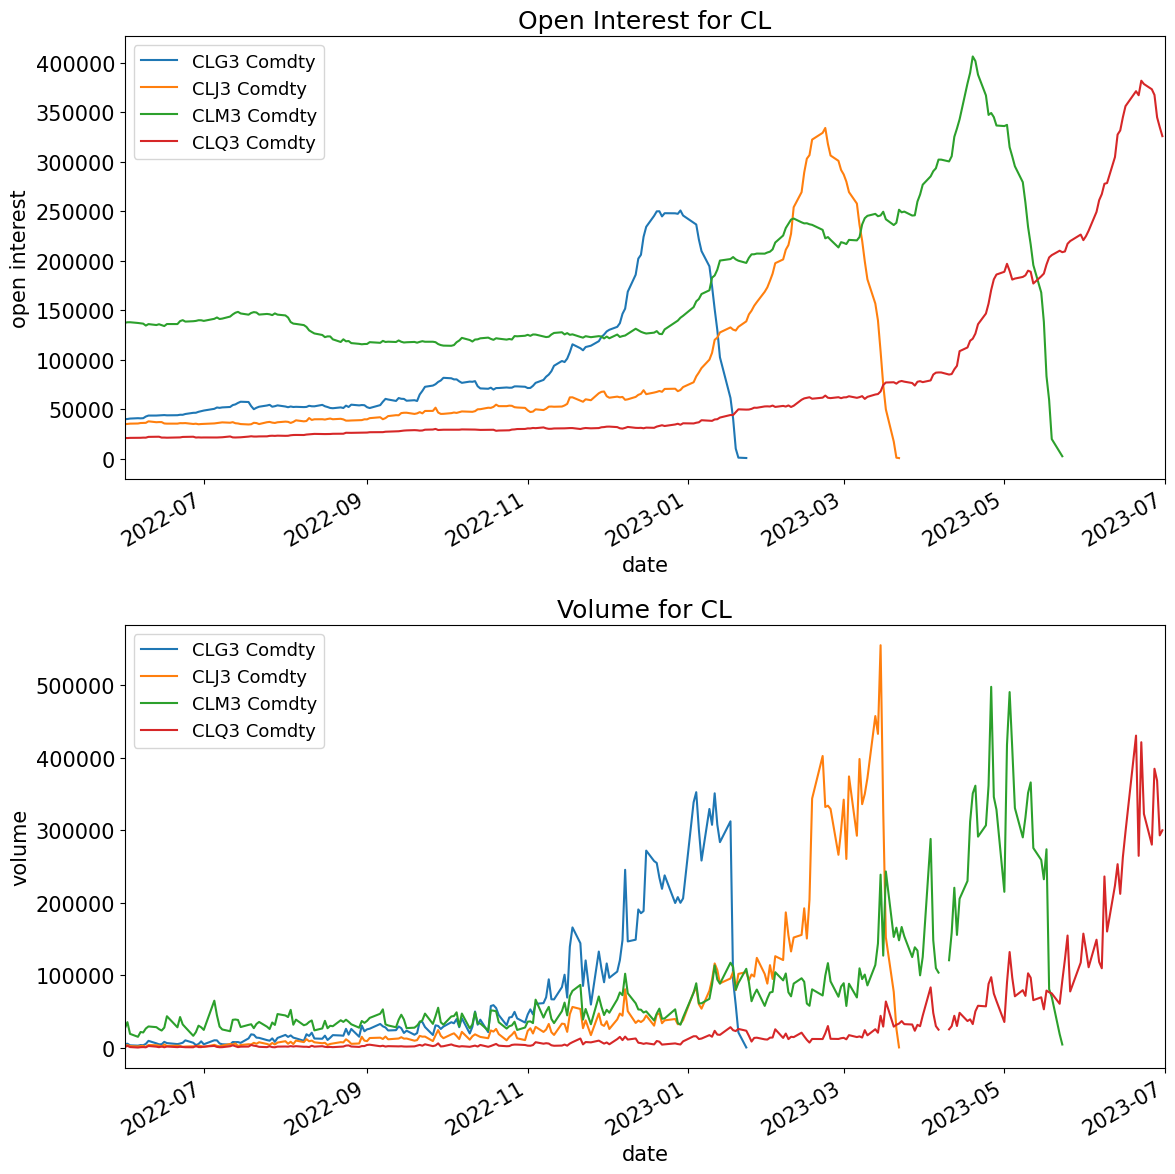

In [14]:
fig, ax = plt.subplots(2,1,figsize=(12,12))
futures_ts['OPEN_INT'].iloc[:,0:4].plot(ax=ax[0],xlim=('2022-06','2023-07'),title=f'Open Interest for {TICKS[0]}',ylabel='open interest')
futures_ts['VOLUME'].iloc[:,0:4].plot(ax=ax[1],xlim=('2022-06','2023-07'),title=f'Volume for {TICKS[0]}',ylabel='volume')
plt.tight_layout()
plt.show()

### Margins and Marking to Market

In [15]:
marg = futures_info[['name']].copy()
marg['margin limit %'] = futures_info['margin limit']/futures_info['contract value']

marg['vol'] = rx.std().values
marg['margin sigma'] = marg['margin limit %'] / marg['vol']
marg.set_index('name',inplace=True)
marg.index = [' '.join(row.split()[:-2]) for row in marg.index]

marg.dropna().sort_values('margin sigma').style.format({'margin limit %':'{:.1%}','vol':'{:.1%}','margin sigma':'{:.1f}'})

,margin limit %,vol,margin sigma
WTI CRUDE,7.8%,3.4%,2.3
LEAN HOGS,5.3%,2.2%,2.4
LIVE CATTLE,2.5%,1.0%,2.5
S&P500 EMINI,4.9%,1.3%,3.8
NATURAL GAS,15.9%,4.1%,3.9
GOLD 100 OZ,4.2%,0.9%,4.5
BP CURRENCY,3.1%,0.6%,5.1
COFFEE 'C',11.6%,2.1%,5.6
CME Bitcoin,25.2%,4.5%,5.6
CORN,9.1%,1.5%,6.2


#### Futures References
The CME provides a helpful series of videos for an introduction to Futures

https://www.cmegroup.com/education/courses/introduction-to-futures/definition-of-a-futures-contract.html

# Pricing

## Forward Price
The basic model of a futures price is:

$$F_0 = S_0 e^{r_f T}$$

This equation is derived by no-arbitrage, in a simplified setting of
* no market frictions
* a constant risk-free rate, $r_f$
* no financing considerations (margin, marking to market, etc)

This is just the **forward pricing** equation.

It says that the futures price should be the spot price compounded by the risk-free rate until delivery.

## Carry
The pricing formula above accounts for the time-value of money, but it does not account for the **carry** cost of the asset.

### Dividend yield
Suppose that the asset pays a dividend yield of $q$
* dividends on stock index
* lease rate on metals

### Storage cost
The asset may be costly to store, such that it has a negative carry.
* oil, grains, etc

### Carry
Let **carry**, $c$, denote the net difference of the storage costs minus income.

Then,
$$F_0 = S_0 e^{(r_f+c)T}$$

That is, the 
* higher the storage costs, the **higher** the futures price.
* higher the income, the **lower** the futures price.

### Convenience Yield

For consumption assets, the no-arbitrage argument is more complicated.
$$F_0 < S_0e^{(r_f+c)T}$$
This is due to the fact that the asset has a **convenience yield**, $y$.

This convenience yield is not explicit income to the owner, but rather potential income should the consumption use of the asset be important during the contract period.

The equation can make explicit note of this,
$$F_0 = S_0e^{(r_f+c-y)T}$$
or simply include the convenience yield as part of the carry.
$$F_0 = S_0e^{(r_f+c^*)T}$$

### Negative Price for Oil?

Typically, carry costs are a second-order factor for prices.

But sometimes market frictions cause them to be of high importance.

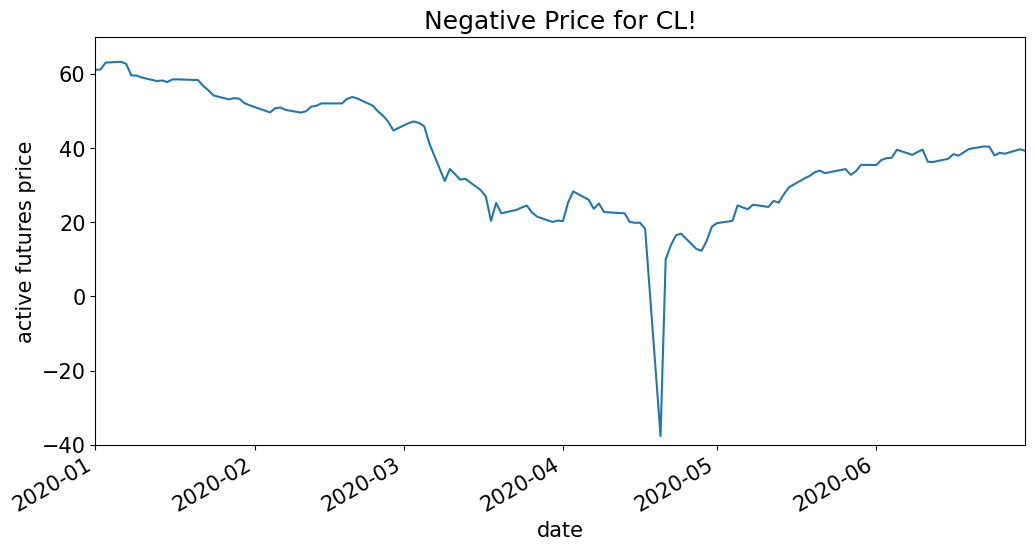

In [16]:
TICK = 'CL'
data_comp = pd.read_excel(LOADFILE,sheet_name=f'roll conventions {TICK}').set_index('date')
data_comp['CL1 Comdty'].plot(xlim=('2020-01-01','2020-06-30'),ylim=(-40,70),title=f'Negative Price for {TICK}!',ylabel='active futures price');

#### References
https://www.nytimes.com/2020/04/20/business/oil-prices.html
https://www.forbes.com/sites/sarahhansen/2020/04/21/heres-what-negative-oil-prices-really-mean/?sh=5530d0185a85

## Complications

There are various complications to the simple model.

### Moving Interest Rates
The formulas above assume a constant interest rate. 

If the interest rate moves, then we would have the following adjustments:
* **Higher** price if asset is **positively** correlated to the asset value
* **Lower** price if asset is **negatively** correlated to the asset value
Why?

### Daily Settlement
Futures contracts are settled daily, which means the cashflows are paid/received day-by-day rather than all at delivery.

#### Terminology
- **Daily Settlement**: The profit/loss of the day is settled via an accrual / deduction from the margin account. This payment is irrevocable. That is to say that it is not collateral but a permanent payment based on the day's movement.

- **Variation Margin**: To reduce counterparty risk in some collateralized trades, (such as repo,) you might need to pay a variation margin when the collateral value goes down. This is a form of collateral: it earns interest on your behalf, and it will be returned at the end of the trade.

- **Mark-to-market**: Revising the price of an asset in the financial records, (such as a balance sheet,) to reflect the market movements in the price. This has no implications for cashflow but rather is a financial accounting revision. This term is often used to refer to teh **daily settlement** mentioned above, but this term is more general.

## Futures vs Forwards

The CME video compares and contrasts.

https://www.cmegroup.com/education/courses/introduction-to-futures/futures-contracts-compared-to-forwards.html

* For each difference, would it cause the price of the future contract to be more or less than the comparable forward?

* Which differences do you think are of most practical importance?

# The Futures Curve

## Defining the Curve

At a given date, consider the full chain of some futures contract:

In [17]:
list_curves = ['CL1','GC1']
curves = dict()
for comdty in list_curves:
    curves[comdty]= pd.read_excel(LOADFILE,sheet_name=f'curve {comdty}')

In [18]:
curves[comdty].style.format({'price':'${:,.2f}', 'open interest':'{:,.0f}'})

,ticker,delivery date,price,open interest
0,GCN3 Comdty,2023-07-03 00:00:00,"$1,952.40",58
1,GCU3 Comdty,2023-09-01 00:00:00,"$1,967.70",557
2,GCZ3 Comdty,2023-12-01 00:00:00,"$1,997.90","218,713"
3,GCJ4 Comdty,2024-04-01 00:00:00,"$2,035.20","5,091"
4,GCQ4 Comdty,2024-08-01 00:00:00,"$2,071.20",460
5,GCZ4 Comdty,2024-12-02 00:00:00,"$2,102.20",799
6,GCJ5 Comdty,2025-04-01 00:00:00,"$2,136.90",0
7,GCZ5 Comdty,2025-12-01 00:00:00,"$2,170.70",9
8,GCZ6 Comdty,2026-12-01 00:00:00,"$2,209.80",2
9,GCZ7 Comdty,2027-12-01 00:00:00,"$2,247.00",0


If we plot this chain against the delivery dates, we get the **futures curve**.

The curves below show the marker sizes in proportion to the open interest of each contract.

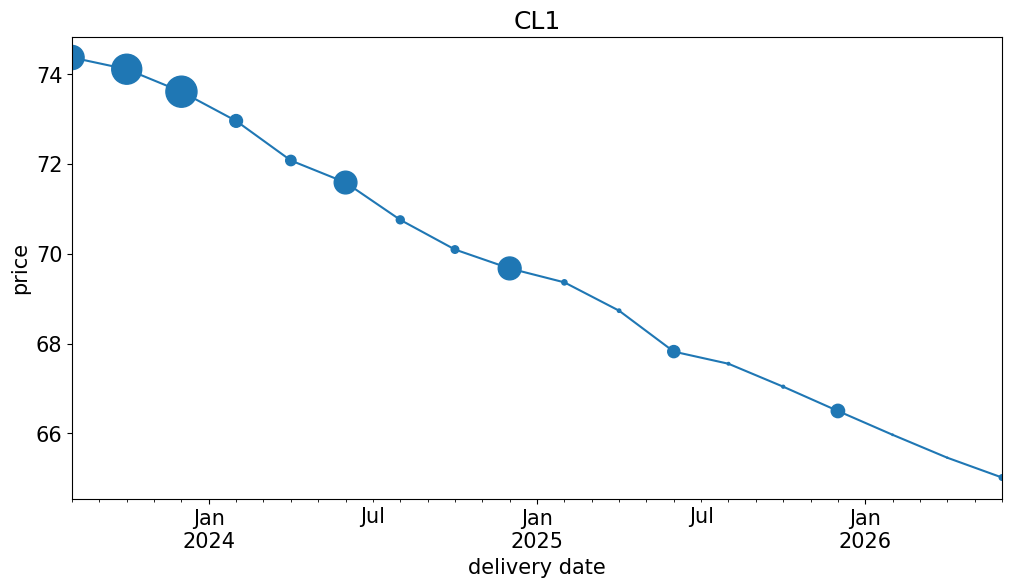

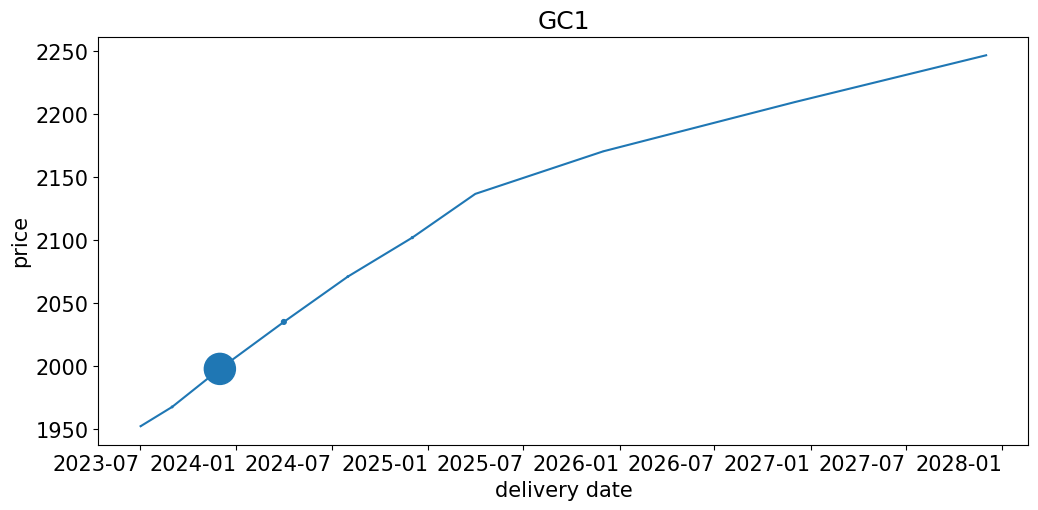

In [19]:
for comdty in list_curves:
    
    temp = curves[comdty].set_index('delivery date').sort_index()
    msize = (temp['open interest']/temp['open interest'].max()) * 500
    
    fig, ax=plt.subplots()
    temp['price'].plot(ax=ax,marker=None,title=comdty)
    temp.reset_index().plot.scatter('delivery date','price',s=msize,ax=ax,title=comdty)
    plt.show()

## Backwardation and Contango

### Relative to expectations
"Normal" Backwardation
* the futures price is **below** the expected future spot

Contango
* the futures price is **above** the expected future spot

### Economics

#### Normal? 
**"Normal"** backwardation refers to economists (Keynes) thinking it should be the "normal" situation to have the futures price below the expected future spot.

The argument depends on the assumption that hedgers (suppliers) would tend to be short the futures contract while market-makers and speculators would be long. The risk aversion of the former group being higher than the latter group might lead to the futures price being pressured below the market forecast

#### Relation to pricing equations above

The simple pricing above implies...
* Contango = **high** carry costs relative to convenience yield
* Backwardation = **low** carry costs relative to convenience yield

### Descriptions of the futures curve

Note that 
* there is not an objective "expected future spot". 
* thus, whether in backwardation or contango would depend on one's model of the forecasted spot price.

In practice, these terms are often used with the assumption that **today's spot is the best prediction of the future spot**:

$\begin{align}
P_t = \boldsymbol{E}_t\left[P_T\right]
\end{align}$

#### Common usage
This leads to the common usage.

Backwardation
* the futures curve is **downward** sloping

Contango
* the futures curve is **upward** sloping

This definition is simpler and can be directly measured. 

#### In the examples above
* Oil is in backwardation
* Gold is in contango

## Roll

Trading futures positions involves **rolling** the position to new contracts.

If the curve is in **contango** this rolling will require buying at a higher price
* add capital to hold same number of contracts
* keep capital flat, but in fewer contracts

If the curve is in **backwardation** this rolling will mean buying at a lower price
* reallocate some capital to hold same number of contracts
* keep capital flat, but in more contracts

The chart below shows price histories for various contracts on the chain, note that when one settles, a trader would have to roll up/down to another contract.

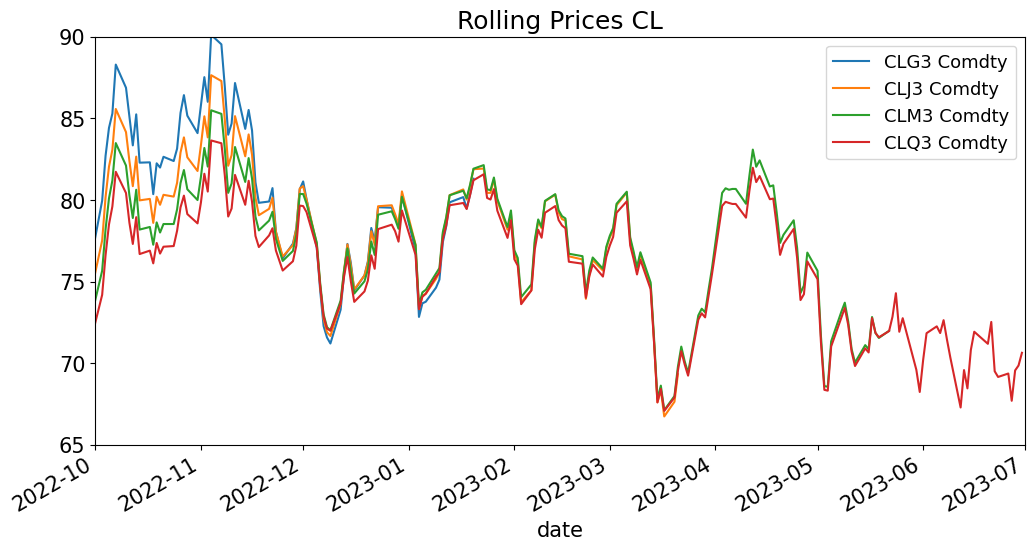

In [20]:
ptitle = futures_ts['LAST_PRICE'].iloc[:,0].name[:2]
futures_ts['LAST_PRICE'].iloc[:,0:4].plot(xlim=('2022-10','2023-07'),ylim=(65,90),title=f'Rolling Prices {ptitle}');

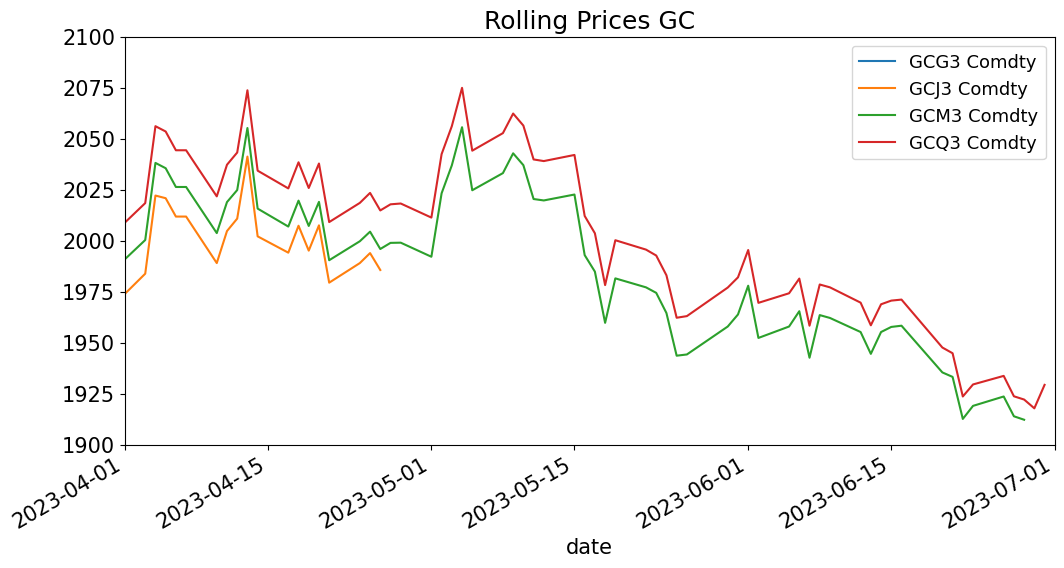

In [21]:
ptitle = futures_ts['LAST_PRICE'].iloc[:,4].name[:2]
futures_ts['LAST_PRICE'].iloc[:,4:].plot(xlim=('2023-04','2023-07'),ylim=(1900,2100),title=f'Rolling Prices {ptitle}');

## Continuous Contract

Given that futures contracts mature and roll off, it can be a challenge to obtain a long history of their prices.

This is similar to getting long timeseries of bond prices.

### Generic indexes
Like with bonds, the answer is to construct a generic index which is the compilation of many short-term instruments.

With bonds, this is done by building so-called "constant maturity" series, which at any point in the past point might point to the bonds closest in maturity to the stated index.

For futures, an index can be constructed by simply pointing to the active contract at any point in time.

### Generic front and back

The common notation is to denote the generic front contract with a "1" and the generic back contract with a "2".

For example, for crude oil, (CL), we have
* CL1
* CL2

The chart below shows these price series.

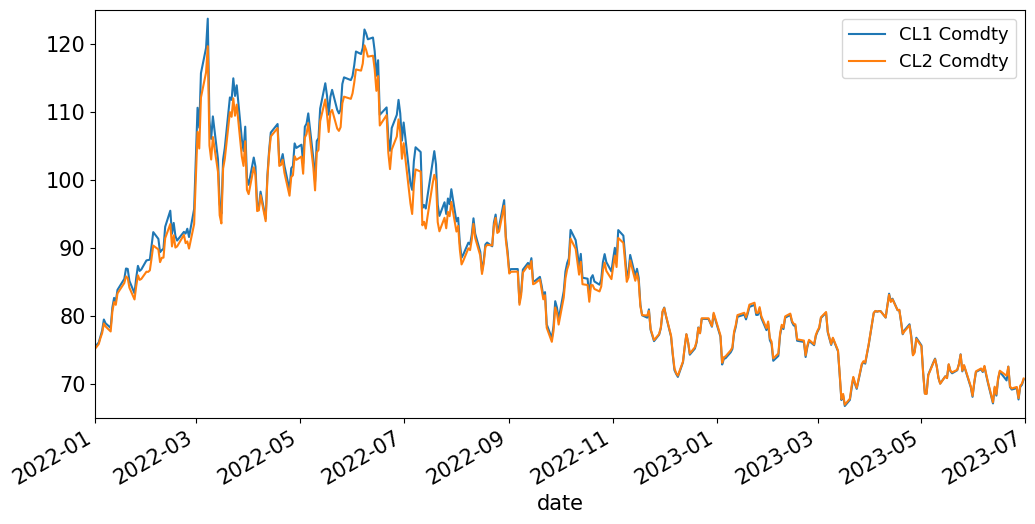

In [22]:
data_comp[['CL1 Comdty','CL2 Comdty']].plot(xlim=('2022-01','2023-07'),ylim=(65,125));

### Rolling the Continuous Series

The complication with the continuous front and back futures series is that at the time of rolling, the price will jump simply due to the roll.

In analyzing the series, it will seem that these jumps are returns, when they are actually just a rebasing of the contract.

If a series tends to be in contango, this will make the returns seem artificially high.

### Adjusting the Continuous Series

To avoid these jumps in the series, it is common to see one of three adjustments made at each roll, going back through time, to keep the breaks continuous.
* difference: adjust the level by an addititive factor
* ratio: adjust the past series by a multiplicative factor 
* weighted average: roll between the front and back contracts over a window of $m$ days, taking a weighted average between the contracts.

The effect of all three adjustments is to
* eliminate jumps at roll dates.
* report true historic prices for the most recent contract used in the continuous series
* report an adjusted price for the earlier contracts used in the continuous series

In these ways, it is similar to the adjustments to equity prices discussed in another note.

#### So which adjustment to use?
* difference: keeps the profit and loss true, which is useful if simulating a particular number of contracts
* ratio: ensures valid return series, which is useful if simulating a particular investment size.

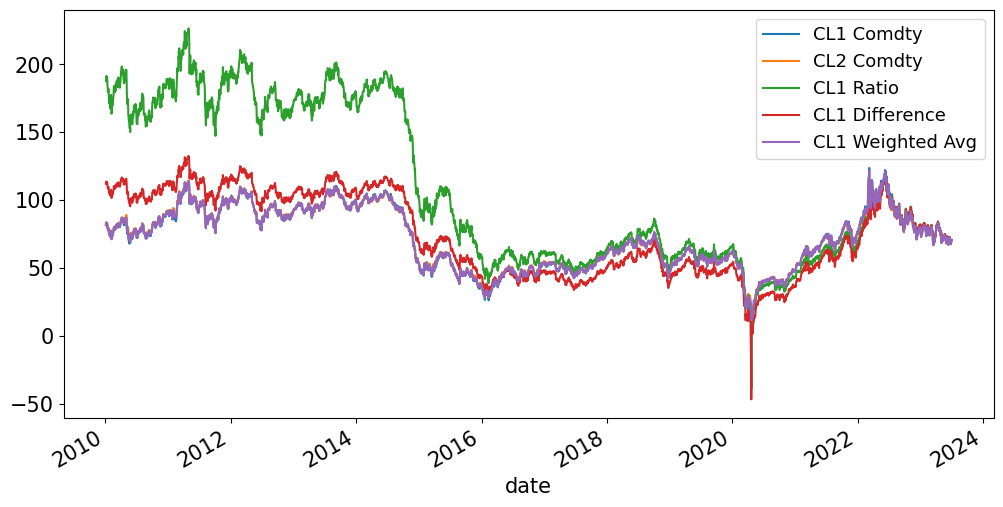

In [23]:
data_comp.plot();

### Roll Rule
There is also a decision to make regarding **when** to roll the contract in the continuous series. The most popular rules are
* fixed date (often first day of the month)
* at contract close
* when the max open interest shifts

#### Careful with the roll method

Using an improper roll method for historic analysis may greatly misrepresent the performance.

Which of these is correct for understanding returns over time?

In [24]:
px = data_comp.copy()
px[px<0] = np.nan
px[px==np.inf] = np.nan
rx_comp = px.pct_change()
performanceMetrics(rx_comp,annualization=252).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
CL1 Comdty,8.8%,43.9%,20.1%,-45.2%,37.7%
CL2 Comdty,8.8%,45.4%,19.4%,-43.4%,78.8%
CL1 Ratio,2.3%,42.9%,5.4%,-45.2%,25.1%
CL1 Difference,37.3%,100.7%,37.1%,-89.8%,235.1%
CL1 Weighted Avg,7.8%,41.7%,18.6%,-30.7%,24.4%
